# Advanced Tutorial 04: Conformal Prediction with MolPipeline

This notebook demonstrates conformal prediction methods for molecular machine learning using MolPipeline. We'll explore both classification and regression tasks using:

1. **Classification**: BBBP (Blood-Brain Barrier Permeability) dataset
2. **Regression**: LogD (Lipophilicity) dataset

## Key Concepts Covered:

### Classification Methods:
- Split Conformal Prediction
- Mondrian Conformal Prediction  
- Cross Conformal Prediction with Mondrian

### Regression Methods:
- Split Conformal Prediction
- Cross Conformal Prediction

### Evaluation Metrics:
- **Classification**: Coverage, Singleton Accuracy, Average Set Size, Singleton Fraction
- **Regression**: MAE, RMSE, R², Interval Width, Coverage

Conformal prediction provides statistically valid uncertainty quantification, giving prediction sets (classification) or intervals (regression) with guaranteed coverage at a specified confidence level.

**Note on Singleton Accuracy**: For classification, we only calculate accuracy on predictions where the conformal prediction set contains exactly one class (singleton predictions). This gives a more meaningful measure of when the model is confident and correct.

In [164]:
# Import required libraries
import warnings
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split

# MolPipeline imports
from molpipeline import ErrorFilter, FilterReinserter, Pipeline
from molpipeline.any2mol import SmilesToMol
from molpipeline.experimental.uncertainty.conformal import (
    ConformalPredictor,
    CrossConformalPredictor,
)
from molpipeline.mol2any import MolToMorganFP

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.default_rng(42)

# Set up plotting style
plt.style.use("default")
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

We'll load molecular datasets and preprocess them using MolPipeline to generate Morgan fingerprints for machine learning.

In [165]:
# Constants for fingerprint generation
FP_RADIUS = 2
FP_SIZE = 1024

# Load datasets
test_data_dir = Path("../tests/test_data")

# Load BBBP dataset for classification
print("Loading BBBP dataset for classification...")
bbbp_df = pd.read_csv(
    test_data_dir / "molecule_net_bbbp.tsv.gz", sep="\t", compression="gzip",
)

# Load LogD dataset for regression
print("Loading LogD dataset for regression...")
logd_df = pd.read_csv(
    test_data_dir / "molecule_net_logd.tsv.gz", sep="\t", compression="gzip",
)

print(f"BBBP dataset shape: {bbbp_df.shape}")
print(f"LogD dataset shape: {logd_df.shape}")
print("\nBBBP dataset columns:", bbbp_df.columns.tolist())
print("LogD dataset columns:", logd_df.columns.tolist())

Loading BBBP dataset for classification...
Loading LogD dataset for regression...
BBBP dataset shape: (1000, 4)
LogD dataset shape: (1000, 3)

BBBP dataset columns: ['num', 'name', 'p_np', 'smiles']
LogD dataset columns: ['CMPD_CHEMBLID', 'exp', 'smiles']


In [166]:
# Preprocessing pipeline for classification (BBBP)
print("Preprocessing BBBP dataset...")
error_filter_clf = ErrorFilter()
pipeline_clf = Pipeline(
    [
        ("smi2mol", SmilesToMol()),
        ("error_filter", error_filter_clf),
        ("morgan", MolToMorganFP(radius=FP_RADIUS, n_bits=FP_SIZE, return_as="dense")),
        (
            "filter_reinserter",
            FilterReinserter.from_error_filter(error_filter_clf, fill_value=np.nan),
        ),
    ],
)

smiles_list_clf = bbbp_df["smiles"]
labels_clf = bbbp_df["p_np"].to_numpy()
fingerprint_matrix_clf = pipeline_clf.fit_transform(smiles_list_clf)

# Remove invalid molecules
valid_mask_clf = ~np.isnan(fingerprint_matrix_clf).any(axis=1)
X_clf = fingerprint_matrix_clf[valid_mask_clf]
y_clf = labels_clf[valid_mask_clf]
smiles_clf = [
    smiles_list_clf.iloc[i] for i in range(len(smiles_list_clf)) if valid_mask_clf[i]
]
# reassign some 0s to 1s to create an imbalanced dataset
rng = np.random.default_rng(42)
one_indices = np.where(y_clf == 1)[0]
to_change = rng.choice(one_indices, size=250, replace=False)
y_clf[to_change] = 0
print(f"Classification dataset: {X_clf.shape[0]} valid molecules")
print(f"Feature shapes: {X_clf.shape}, {y_clf.shape}")
print(f"Class distribution: {np.bincount(y_clf)}")

# Preprocessing pipeline for regression (LogD)
print("\nPreprocessing LogD dataset...")
error_filter_reg = ErrorFilter()
pipeline_reg = Pipeline(
    [
        ("smi2mol", SmilesToMol()),
        ("error_filter", error_filter_reg),
        ("morgan", MolToMorganFP(radius=FP_RADIUS, n_bits=FP_SIZE, return_as="dense")),
        (
            "filter_reinserter",
            FilterReinserter.from_error_filter(error_filter_reg, fill_value=np.nan),
        ),
    ],
)

smiles_list_reg = logd_df["smiles"]
labels_reg = logd_df["exp"].to_numpy()
fingerprint_matrix_reg = pipeline_reg.fit_transform(smiles_list_reg)

# Remove invalid molecules
valid_mask_reg = ~np.isnan(fingerprint_matrix_reg).any(axis=1)
X_reg = fingerprint_matrix_reg[valid_mask_reg]
y_reg = labels_reg[valid_mask_reg]
smiles_reg = [
    smiles_list_reg.iloc[i] for i in range(len(smiles_list_reg)) if valid_mask_reg[i]
]

print(f"Regression dataset: {X_reg.shape[0]} valid molecules")
print(f"Feature shapes: {X_reg.shape}, {y_reg.shape}")
print(
    f"Target statistics: mean={np.mean(y_reg):.2f}, std={np.std(y_reg):.2f},"
    f"min={np.min(y_reg):.2f}, max={np.max(y_reg):.2f}",
)

Preprocessing BBBP dataset...
Classification dataset: 989 valid molecules
Feature shapes: (989, 1024), (989,)
Class distribution: [729 260]

Preprocessing LogD dataset...
Classification dataset: 989 valid molecules
Feature shapes: (989, 1024), (989,)
Class distribution: [729 260]

Preprocessing LogD dataset...


[02:02:21] Explicit valence for atom # 1 N, 4, is greater than permitted
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] Explicit valence for atom # 6 N, 4, is greater than permitted
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] Explicit valence for atom # 6 N, 4, is greater than permitted
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] WARNING: not removing hydrogen atom without neighbors
[02:02:21] Explicit valence for atom # 11 N, 4, is greater than pe

Regression dataset: 1000 valid molecules
Feature shapes: (1000, 1024), (1000,)
Target statistics: mean=2.22, std=1.18,min=-1.40, max=4.50


In [167]:
# Utility functions for evaluation
def evaluate_classification_conformal(
    y_true: np.ndarray,
    prediction_sets: list[list[int]],
) -> dict[str, Any]:
    """Evaluate conformal prediction for classification.

    Returns
    -------
    dict[str, float]
        A dictionary containing evaluation metrics for the conformal prediction.

    """
    len(y_true)

    # Coverage
    coverage = np.mean(
        [y_true[i] in pred_set for i, pred_set in enumerate(prediction_sets)],
    )

    # Average set size
    avg_set_size = np.mean([len(pred_set) for pred_set in prediction_sets])

    # Singleton accuracy: accuracy only for predictions with exactly one element
    singleton_mask = np.array([len(pred_set) == 1 for pred_set in prediction_sets])
    singleton_accuracies = {}

    if np.sum(singleton_mask) > 0:
        # Get singleton predictions
        singleton_predictions = np.array(
            [pred_set[0] if len(pred_set) == 1 else -1 for pred_set in prediction_sets],
        )

        # Calculate class-specific singleton accuracies
        for cls in np.unique(y_true):
            # Mask for this class AND singleton predictions
            class_singleton_mask = singleton_mask & (y_true == cls)

            if np.sum(class_singleton_mask) > 0:
                # Calculate accuracy for this class's singleton predictions
                y_true_class_singleton = y_true[class_singleton_mask]
                y_pred_class_singleton = singleton_predictions[class_singleton_mask]
                singleton_accuracies[cls] = accuracy_score(
                    y_true_class_singleton, y_pred_class_singleton,
                )
            else:
                singleton_accuracies[cls] = (
                    np.nan
                )  # No singleton predictions for this class
    else:
        # No singleton predictions at all
        for cls in np.unique(y_true):
            singleton_accuracies[cls] = np.nan

    # Calculate singleton fraction
    singleton_fraction = np.mean(singleton_mask)

    return {
        "coverage": coverage,
        "avg_set_size": avg_set_size,
        "singleton_accuracies": singleton_accuracies,
        "singleton_fraction": singleton_fraction,
    }


def evaluate_regression_conformal(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    intervals: np.ndarray,
) -> dict[str, float]:
    """Evaluate conformal prediction for regression.

    Returns
    -------
    dict[str, float]
        A dictionary containing evaluation metrics for the conformal prediction.

    """
    # Coverage
    coverage = np.mean((y_true >= intervals[:, 0]) & (y_true <= intervals[:, 1]))

    # Interval width
    avg_interval_width = np.mean(intervals[:, 1] - intervals[:, 0])

    # Standard regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return {
        "coverage": coverage,
        "avg_interval_width": avg_interval_width,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
    }


def get_train_calib_test_splits(
    x: np.ndarray,
    y: np.ndarray,
    test_size: float = 0.2,
    calib_size: float = 0.25,
    random_state: int = 42,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Split data into train, calibration, and test sets.

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        The train, calibration, and test splits for features and targets.

    """
    # Use stratification only for classification (discrete targets with few unique vals)
    limit = 10
    stratify_y = y if len(np.unique(y)) < limit else None

    x_train_all, x_test, y_train_all, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state, stratify=stratify_y,
    )

    # Use stratification for the second split only if appropriate
    stratify_y_train = y_train_all if len(np.unique(y)) < limit else None

    x_train, x_calib, y_train, y_calib = train_test_split(
        x_train_all,
        y_train_all,
        test_size=calib_size,
        random_state=random_state,
        stratify=stratify_y_train,
    )
    return x_train, x_calib, x_test, y_train, y_calib, y_test


print("Utility functions defined successfully!")

Utility functions defined successfully!


# Classification: BBBP Blood-Brain Barrier Permeability

We'll demonstrate conformal prediction for binary classification using the BBBP dataset. The task is to predict whether a molecule can cross the blood-brain barrier.

## 1. Split Conformal Prediction

Split conformal prediction uses separate datasets for training and calibration to provide statistically valid prediction sets.

In [168]:
# Split data for classification
x_train_clf, x_calib_clf, x_test_clf, y_train_clf, y_calib_clf, y_test_clf = (
    get_train_calib_test_splits(X_clf, y_clf, random_state=42)
)

print("Classification data splits:")
print(f"Train: {x_train_clf.shape[0]} samples")
print(f"Calibration: {x_calib_clf.shape[0]} samples")
print(f"Test: {x_test_clf.shape[0]} samples")

# Train base classifier
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create split conformal predictor
confidence_level = 0.9
split_cp_clf = ConformalPredictor(
    base_clf, estimator_type="classifier", confidence_level=confidence_level,
)

# Fit and calibrate
print("\nTraining split conformal predictor...")
split_cp_clf.fit(x_train_clf, y_train_clf)
split_cp_clf.calibrate(x_calib_clf, y_calib_clf)

# Make predictions
y_pred_proba_split = split_cp_clf.predict_proba(x_test_clf)
prediction_sets_split = split_cp_clf.predict_conformal_set(
    x_test_clf, confidence=confidence_level,
)

# Evaluate
results_split_clf = evaluate_classification_conformal(
    y_test_clf, prediction_sets_split,
)

print(f"\nSplit Conformal Prediction Results (confidence={confidence_level}):")
print(f"Coverage: {results_split_clf['coverage']:.3f}")
print(f"Average Set Size: {results_split_clf['avg_set_size']:.3f}")
print(f"Singleton Fraction: {results_split_clf['singleton_fraction']:.3f}")
print(
    f"Class 0 Singleton Accuracy:{results_split_clf['singleton_accuracies'][0]:.3f}",
)
print(
    f"Class 1 Singleton Accuracy:{results_split_clf['singleton_accuracies'][1]:.3f}",
)

Classification data splits:
Train: 593 samples
Calibration: 198 samples
Test: 198 samples

Training split conformal predictor...

Split Conformal Prediction Results (confidence=0.9):
Coverage: 0.889
Average Set Size: 1.374
Singleton Fraction: 0.626
Class 0 Singleton Accuracy:0.980
Class 1 Singleton Accuracy:0.167

Split Conformal Prediction Results (confidence=0.9):
Coverage: 0.889
Average Set Size: 1.374
Singleton Fraction: 0.626
Class 0 Singleton Accuracy:0.980
Class 1 Singleton Accuracy:0.167


## 2. Mondrian Conformal Prediction

Mondrian conformal prediction provides class-conditional validity, ensuring coverage guarantees for each class separately.

In [169]:
# Create Mondrian conformal predictor with class-conditional calibration
mondrian_cp_clf = ConformalPredictor(
    RandomForestClassifier(n_estimators=100, random_state=42),
    estimator_type="classifier",
    confidence_level=confidence_level,
    mondrian=True,  # Enable class-conditional calibration
)

# Fit and calibrate
print("Training Mondrian conformal predictor...")
mondrian_cp_clf.fit(x_train_clf, y_train_clf)
mondrian_cp_clf.calibrate(x_calib_clf, y_calib_clf)

# Make predictions
y_pred_proba_mondrian = mondrian_cp_clf.predict_proba(x_test_clf)
prediction_sets_mondrian = mondrian_cp_clf.predict_conformal_set(
    x_test_clf, confidence=confidence_level,
)

# Evaluate
results_mondrian_clf = evaluate_classification_conformal(
    y_test_clf, prediction_sets_mondrian,
)

print(f"\nMondrian Conformal Prediction Results (confidence={confidence_level}):")
print(f"Coverage: {results_mondrian_clf['coverage']:.3f}")
print(f"Average Set Size: {results_mondrian_clf['avg_set_size']:.3f}")
print(f"Singleton Fraction: {results_mondrian_clf['singleton_fraction']:.3f}")
print(
    f"Class 0 Singleton Accuracy:{results_mondrian_clf['singleton_accuracies'][0]:.3f}",
)
print(
    f"Class 1 Singleton Accuracy:{results_mondrian_clf['singleton_accuracies'][1]:.3f}",
)

Training Mondrian conformal predictor...

Mondrian Conformal Prediction Results (confidence=0.9):
Coverage: 0.904
Average Set Size: 1.586
Singleton Fraction: 0.414
Class 0 Singleton Accuracy:0.766
Class 1 Singleton Accuracy:0.778

Mondrian Conformal Prediction Results (confidence=0.9):
Coverage: 0.904
Average Set Size: 1.586
Singleton Fraction: 0.414
Class 0 Singleton Accuracy:0.766
Class 1 Singleton Accuracy:0.778


## 3. Cross Conformal Prediction with Mondrian

Cross conformal prediction uses all available data for both training and calibration through cross-validation, providing more efficient use of data.

In [170]:
# For cross conformal, we use the combined training and calibration data
x_train_calib_clf = np.vstack([x_train_clf, x_calib_clf])
y_train_calib_clf = np.hstack([y_train_clf, y_calib_clf])

# Create cross conformal predictor with Mondrian
cross_cp_clf = CrossConformalPredictor(
    RandomForestClassifier(n_estimators=100, random_state=42),
    n_folds=5,
    confidence_level=confidence_level,
    mondrian=True,  # Enable class-conditional calibration
    random_state=42,
)

# Fit (automatically performs cross-validation and calibration)
print("Training cross conformal predictor with Mondrian...")
cross_cp_clf.fit(x_train_calib_clf, y_train_calib_clf)

# Make predictions
y_pred_proba_cross = cross_cp_clf.predict_proba(x_test_clf)
prediction_sets_cross = cross_cp_clf.predict_conformal_set(
    x_test_clf, confidence=confidence_level,
)

# Evaluate
results_cross_clf = evaluate_classification_conformal(
    y_test_clf, prediction_sets_cross,
)

print(f"\nCross Conformal Prediction Results (confidence={confidence_level}):")
print(f"Coverage: {results_cross_clf['coverage']:.3f}")
print(f"Average Set Size: {results_cross_clf['avg_set_size']:.3f}")
print(f"Singleton Fraction: {results_cross_clf['singleton_fraction']:.3f}")
print(
    f"Class 0 Singleton Accuracy: {results_cross_clf['singleton_accuracies'][0]:.3f}",
)
print(
    f"Class 1 Singleton Accuracy: {results_cross_clf['singleton_accuracies'][1]:.3f}",
)

Training cross conformal predictor with Mondrian...

Cross Conformal Prediction Results (confidence=0.9):
Coverage: 0.944
Average Set Size: 1.712
Singleton Fraction: 0.288
Class 0 Singleton Accuracy: 0.833
Class 1 Singleton Accuracy: 0.667

Cross Conformal Prediction Results (confidence=0.9):
Coverage: 0.944
Average Set Size: 1.712
Singleton Fraction: 0.288
Class 0 Singleton Accuracy: 0.833
Class 1 Singleton Accuracy: 0.667


## 4. Classification Results Comparison
    

Classification Methods Comparison:
                       Method  Coverage  Avg Set Size  Singleton Fraction  \
0             Split Conformal     0.889         1.374               0.626   
1          Mondrian Conformal     0.904         1.586               0.414   
2  Cross Conformal + Mondrian     0.944         1.712               0.288   

   Class 0 Singleton Accuracy  Class 1 Singleton Accuracy  
0                       0.980                       0.167  
1                       0.766                       0.778  
2                       0.833                       0.667  


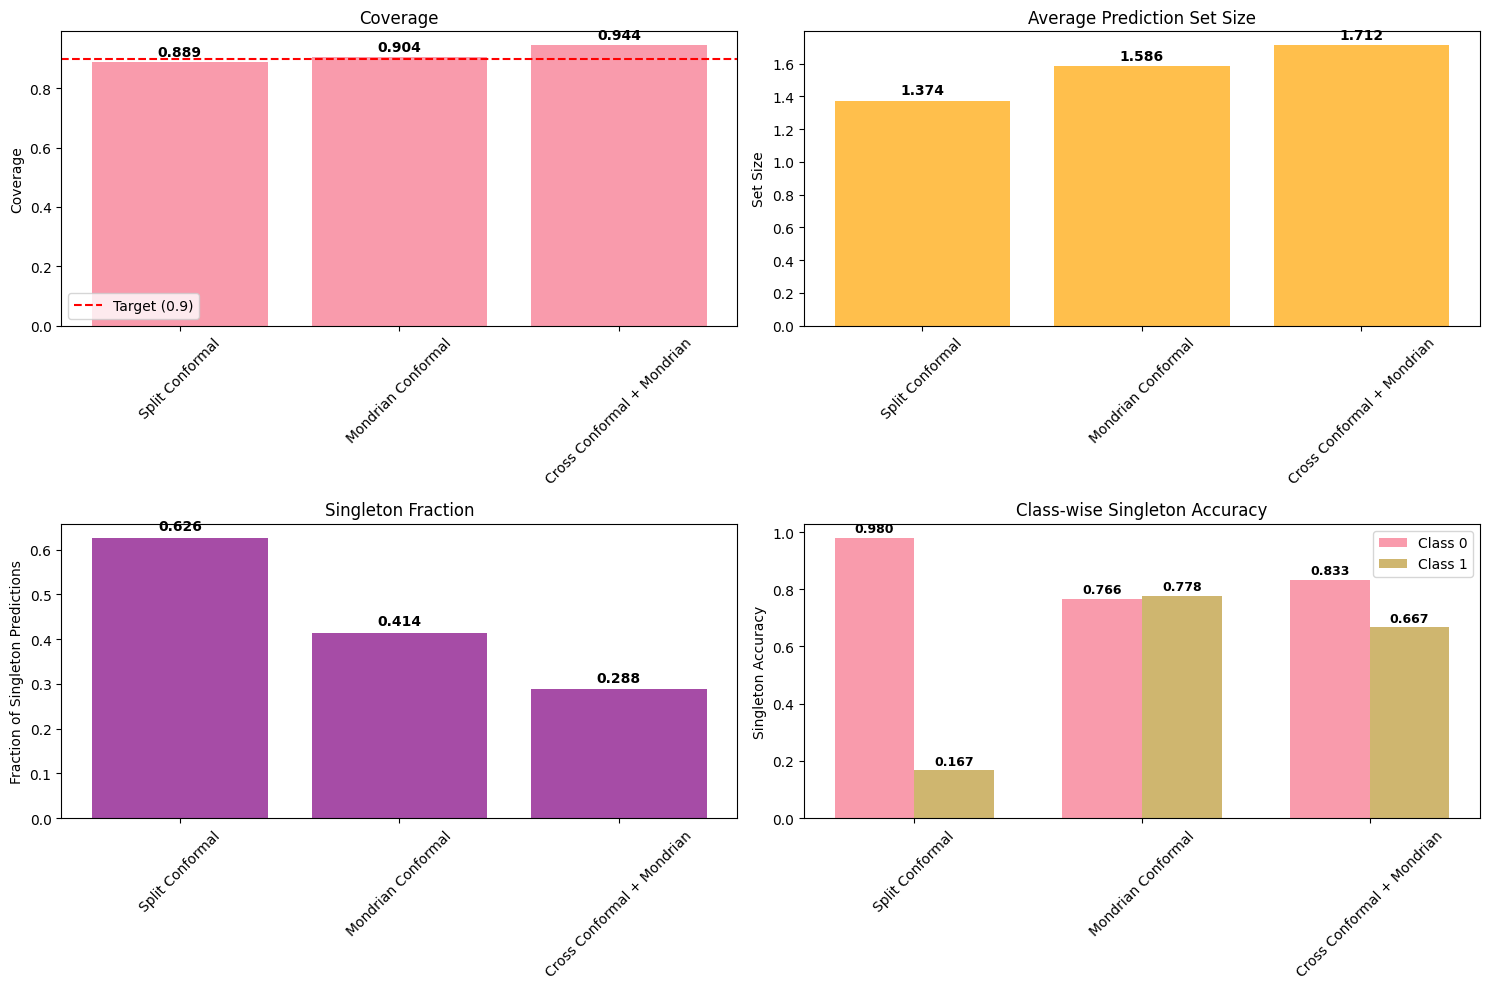

In [171]:
# Create comparison table for classification results
comparison_clf = pd.DataFrame(
    {
        "Method": [
            "Split Conformal",
            "Mondrian Conformal",
            "Cross Conformal + Mondrian",
        ],
        "Coverage": [
            results_split_clf["coverage"],
            results_mondrian_clf["coverage"],
            results_cross_clf["coverage"],
        ],
        "Avg Set Size": [
            results_split_clf["avg_set_size"],
            results_mondrian_clf["avg_set_size"],
            results_cross_clf["avg_set_size"],
        ],
        "Singleton Fraction": [
            results_split_clf["singleton_fraction"],
            results_mondrian_clf["singleton_fraction"],
            results_cross_clf["singleton_fraction"],
        ],
        "Class 0 Singleton Accuracy": [
            results_split_clf["singleton_accuracies"][0],
            results_mondrian_clf["singleton_accuracies"][0],
            results_cross_clf["singleton_accuracies"][0],
        ],
        "Class 1 Singleton Accuracy": [
            results_split_clf["singleton_accuracies"][1],
            results_mondrian_clf["singleton_accuracies"][1],
            results_cross_clf["singleton_accuracies"][1],
        ],
    },
)

print("Classification Methods Comparison:")
print("=" * 50)
print(comparison_clf.round(3))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Coverage comparison
bars1 = axes[0, 0].bar(comparison_clf["Method"], comparison_clf["Coverage"], alpha=0.7)
axes[0, 0].axhline(
    y=confidence_level,
    color="red",
    linestyle="--",
    label=f"Target ({confidence_level})",
)
axes[0, 0].set_title("Coverage")
axes[0, 0].set_ylabel("Coverage")
axes[0, 0].legend()
axes[0, 0].tick_params(axis="x", rotation=45)
# Add values on top of bars
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Average set size comparison
bars2 = axes[0, 1].bar(
    comparison_clf["Method"], comparison_clf["Avg Set Size"], alpha=0.7, color="orange",
)
axes[0, 1].set_title("Average Prediction Set Size")
axes[0, 1].set_ylabel("Set Size")
axes[0, 1].tick_params(axis="x", rotation=45)
# Add values on top of bars
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.02,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Singleton fraction comparison
bars3 = axes[1, 0].bar(
    comparison_clf["Method"],
    comparison_clf["Singleton Fraction"],
    alpha=0.7,
    color="purple",
)
axes[1, 0].set_title("Singleton Fraction")
axes[1, 0].set_ylabel("Fraction of Singleton Predictions")
axes[1, 0].tick_params(axis="x", rotation=45)
# Add values on top of bars
for bar in bars3:
    height = bar.get_height()
    axes[1, 0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Singleton accuracy comparison
methods = comparison_clf["Method"]
class_0_acc = comparison_clf["Class 0 Singleton Accuracy"]
class_1_acc = comparison_clf["Class 1 Singleton Accuracy"]

x = np.arange(len(methods))
width = 0.35

bars4 = axes[1, 1].bar(x - width / 2, class_0_acc, width, label="Class 0", alpha=0.7)
bars5 = axes[1, 1].bar(x + width / 2, class_1_acc, width, label="Class 1", alpha=0.7)
axes[1, 1].set_title("Class-wise Singleton Accuracy")
axes[1, 1].set_ylabel("Singleton Accuracy")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(methods, rotation=45)
axes[1, 1].legend()
# Add values on top of bars for Class 0
for bar in bars4:
    height = bar.get_height()
    if not np.isnan(height):
        axes[1, 1].text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=9,
        )
    else:
        axes[1, 1].text(
            bar.get_x() + bar.get_width() / 2.0,
            0.5,
            "N/A",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=9,
        )
# Add values on top of bars for Class 1
for bar in (bars5):
    height = bar.get_height()
    if not np.isnan(height):
        axes[1, 1].text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=9,
        )
    else:
        axes[1, 1].text(
            bar.get_x() + bar.get_width() / 2.0,
            0.5,
            "N/A",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

### Observations from Classification Results

The comparison plots reveal several key insights about conformal prediction methods for classification in imbalanceds scenarios.

**Coverage Performance**: All three methods achieve coverage very close to the target 90% confidence level, with Cross Conformal + Mondrian showing the most precise coverage (surpassing it to 0.944). This demonstrates that conformal prediction provides reliable statistical guarantees.

**Prediction Set Efficiency**: 
- **Average Set Size**: Cross Conformal + Mondrian produces the largest prediction sets (~1.702), indicating the leasr decisive predictions
- **Singleton Fraction**: All methods achieve low singleton fractions, meaning most predictions are not confident single-class predictions

**Accuracy Analysis**: 
- **Class 0 (Non-BBB)**: Split CP shows very high accuracies for class 0 but is not able to discriminate class 1. Mondrian (class-conditional) CP balances the accuracy across classes 
- **Class 1 (BBB-permeable)**: singleton accuracy for class 1 (~88-89%) reflects the greater difficulty in predicting the minority class, which is expected given the class imbalance

**Method Comparison**: Cross Conformal with Mondrian calibration appears to provide reliable coverage and albeit the most large prediction sets, it maintains high accuracies in both classes.

## 5. Effect of Confidence Level on Classification Performance

Let's analyze how different confidence levels affect the performance of cross conformal prediction with Mondrian calibration for classification.

Analyzing confidence level effects on classification...
Confidence 0.70: Coverage=0.783, Avg Set Size=1.278, Singleton Fraction=0.722
Confidence 0.75: Coverage=0.848, Avg Set Size=1.439, Singleton Fraction=0.561
Confidence 0.80: Coverage=0.889, Avg Set Size=1.500, Singleton Fraction=0.500
Confidence 0.85: Coverage=0.904, Avg Set Size=1.581, Singleton Fraction=0.419
Confidence 0.90: Coverage=0.949, Avg Set Size=1.707, Singleton Fraction=0.293
Confidence 0.95: Coverage=0.985, Avg Set Size=1.864, Singleton Fraction=0.136


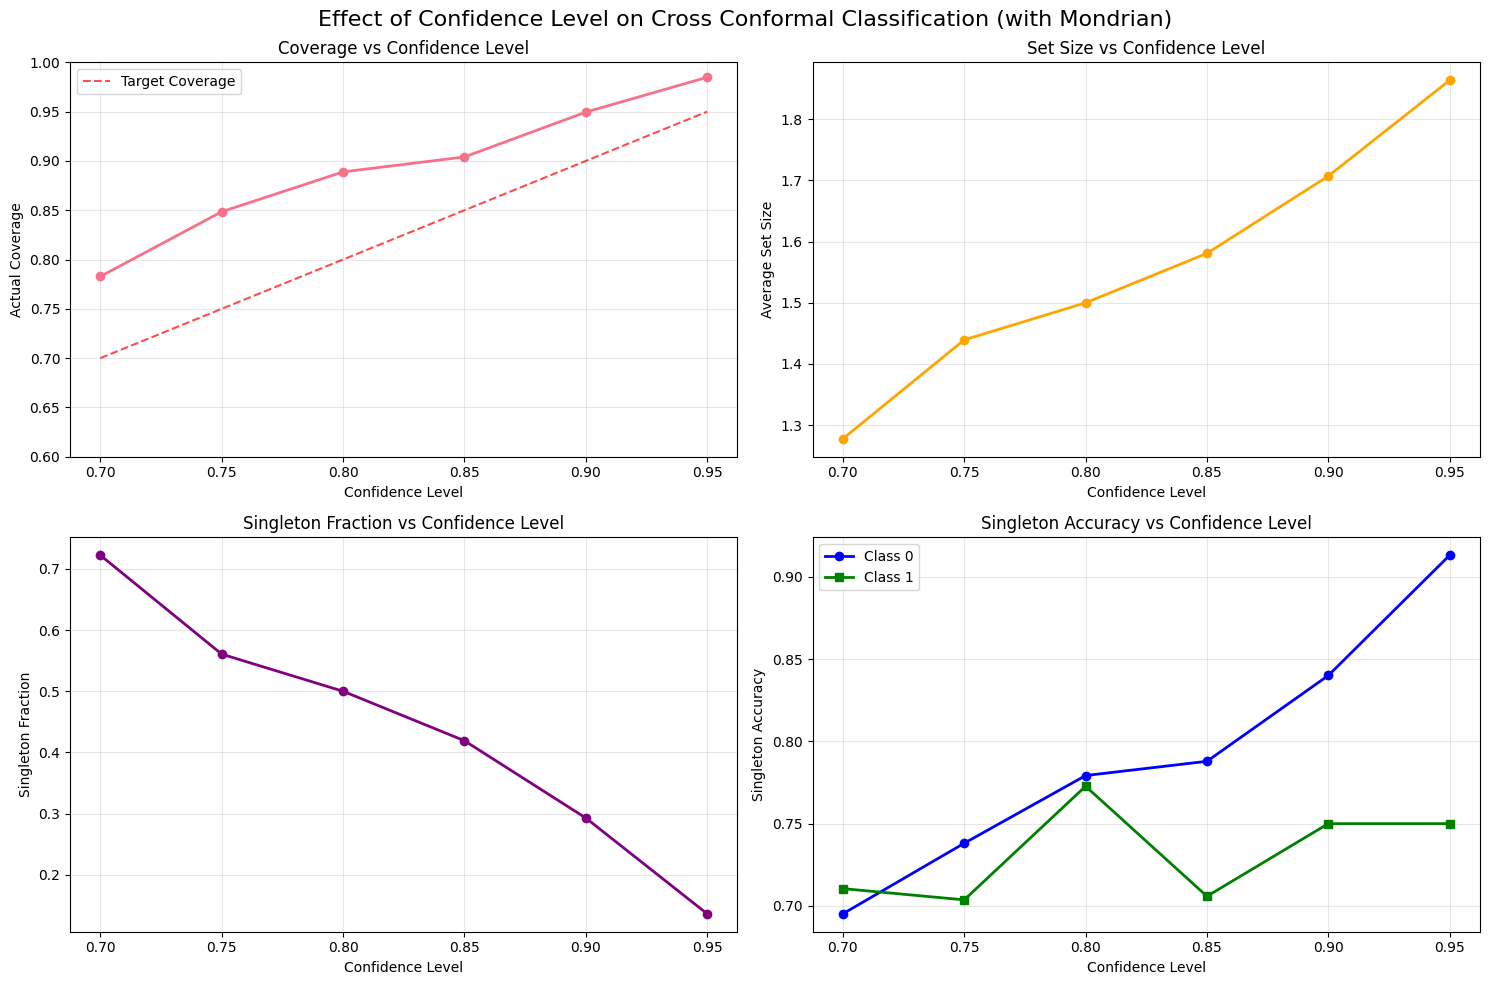


Classification Confidence Level Analysis Summary:
   confidence_level  coverage  avg_set_size  singleton_fraction  \
0              0.70     0.783         1.278               0.722   
1              0.75     0.848         1.439               0.561   
2              0.80     0.889         1.500               0.500   
3              0.85     0.904         1.581               0.419   
4              0.90     0.949         1.707               0.293   
5              0.95     0.985         1.864               0.136   

   class_0_singleton_acc  class_1_singleton_acc  
0                  0.695                  0.711  
1                  0.738                  0.704  
2                  0.779                  0.773  
3                  0.788                  0.706  
4                  0.840                  0.750  
5                  0.913                  0.750  


In [172]:
# Analyze different confidence levels for classification
confidence_levels = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
clf_confidence_results = []

print("Analyzing confidence level effects on classification...")
for conf_level in confidence_levels:
    # Use the already trained cross conformal predictor
    prediction_sets_conf = cross_cp_clf.predict_conformal_set(
        x_test_clf, confidence=conf_level,
    )

    # Evaluate
    results_conf = evaluate_classification_conformal(
        y_test_clf, prediction_sets_conf,
    )

    clf_confidence_results.append(
        {
            "confidence_level": conf_level,
            "coverage": results_conf["coverage"],
            "avg_set_size": results_conf["avg_set_size"],
            "singleton_fraction": results_conf["singleton_fraction"],
            "class_0_singleton_acc": results_conf["singleton_accuracies"][0],
            "class_1_singleton_acc": results_conf["singleton_accuracies"][1],
        },
    )

    print(
        f"Confidence {conf_level:.2f}: Coverage={results_conf['coverage']:.3f}, "
        f"Avg Set Size={results_conf['avg_set_size']:.3f}, "
        f"Singleton Fraction={results_conf['singleton_fraction']:.3f}",
    )

# Convert to DataFrame for easier plotting
clf_conf_df = pd.DataFrame(clf_confidence_results)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(
    "Effect of Confidence Level on Cross Conformal Classification (with Mondrian)",
    fontsize=16,
)

# Coverage vs confidence level
axes[0, 0].plot(
    clf_conf_df["confidence_level"],
    clf_conf_df["coverage"],
    "o-",
    linewidth=2,
    markersize=6,
)
axes[0, 0].plot(
    clf_conf_df["confidence_level"],
    clf_conf_df["confidence_level"],
    "--",
    color="red",
    alpha=0.7,
    label="Target Coverage",
)
axes[0, 0].set_xlabel("Confidence Level")
axes[0, 0].set_ylabel("Actual Coverage")
axes[0, 0].set_title("Coverage vs Confidence Level")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0.6, 1.0)

# Average set size vs confidence level
axes[0, 1].plot(
    clf_conf_df["confidence_level"],
    clf_conf_df["avg_set_size"],
    "o-",
    linewidth=2,
    markersize=6,
    color="orange",
)
axes[0, 1].set_xlabel("Confidence Level")
axes[0, 1].set_ylabel("Average Set Size")
axes[0, 1].set_title("Set Size vs Confidence Level")
axes[0, 1].grid(True, alpha=0.3)

# Singleton fraction vs confidence level
axes[1, 0].plot(
    clf_conf_df["confidence_level"],
    clf_conf_df["singleton_fraction"],
    "o-",
    linewidth=2,
    markersize=6,
    color="purple",
)
axes[1, 0].set_xlabel("Confidence Level")
axes[1, 0].set_ylabel("Singleton Fraction")
axes[1, 0].set_title("Singleton Fraction vs Confidence Level")
axes[1, 0].grid(True, alpha=0.3)

# Singleton accuracies vs confidence level
axes[1, 1].plot(
    clf_conf_df["confidence_level"],
    clf_conf_df["class_0_singleton_acc"],
    "o-",
    linewidth=2,
    markersize=6,
    label="Class 0",
    color="blue",
)
axes[1, 1].plot(
    clf_conf_df["confidence_level"],
    clf_conf_df["class_1_singleton_acc"],
    "s-",
    linewidth=2,
    markersize=6,
    label="Class 1",
    color="green",
)
axes[1, 1].set_xlabel("Confidence Level")
axes[1, 1].set_ylabel("Singleton Accuracy")
axes[1, 1].set_title("Singleton Accuracy vs Confidence Level")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClassification Confidence Level Analysis Summary:")
print("=" * 60)
print(clf_conf_df.round(3))

### Observations from Confidence Level Analysis (Classification)

The confidence level analysis reveals important trade-offs in conformal prediction behavior:

**Coverage Calibration**: The actual coverage closely tracks the target confidence levels (red dashed line), confirming that conformal prediction provides statistically valid guarantees. The slight deviations are expected due to finite sample effects.

**Efficiency vs. Confidence Trade-off**:
- **Set Size**: As confidence increases from 70% to 95%, average prediction set size grows from ~1.25 to ~1.85, indicating that higher confidence requires larger (less decisive) prediction sets
- **Singleton Fraction**: Decreases from ~0.8 to ~0.1 as confidence increases, showing that demanding higher confidence results in more ambiguous predictions

**Accuracy Patterns**:
- **Class 0**: Ranges between ~75-90% and it tends to increase mainly due to the lower number of singletons
- **Class 1**: Shows more variation (~70-90%) and slight improvement at higher confidence levels, suggesting that when the model is forced to be more conservative, its predictions for the minority class become more reliable

**Practical Implications**: The sweet spot appears to be around 85-90% confidence, where we maintain high singleton fractions (decisive predictions) while achieving good coverage and accuracy across both classes.

# Regression: LogD Lipophilicity Prediction

Now we'll demonstrate conformal prediction for regression using the LogD dataset. The task is to predict the lipophilicity (LogD) values of molecules.

## 1. Split Conformal Prediction for Regression

In [173]:
# Split data for regression
x_train_reg, x_calib_reg, x_test_reg, y_train_reg, y_calib_reg, y_test_reg = (
    get_train_calib_test_splits(X_reg, y_reg, random_state=42)
)

print("Regression data splits:")
print(f"Train: {x_train_reg.shape[0]} samples")
print(f"Calibration: {x_calib_reg.shape[0]} samples")
print(f"Test: {x_test_reg.shape[0]} samples")

# Train base regressor
base_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Create split conformal predictor for regression
split_cp_reg = ConformalPredictor(
    base_reg, estimator_type="regressor", confidence_level=confidence_level,
)

# Fit and calibrate
print("\nTraining split conformal predictor for regression...")
split_cp_reg.fit(x_train_reg, y_train_reg)
split_cp_reg.calibrate(x_calib_reg, y_calib_reg)

# Make predictions
y_pred_split_reg = split_cp_reg.predict(x_test_reg)
intervals_split = split_cp_reg.predict_int(x_test_reg, confidence=confidence_level)

# Evaluate
results_split_reg = evaluate_regression_conformal(
    y_test_reg, y_pred_split_reg, intervals_split,
)

print(f"\nSplit Conformal Prediction Results (confidence={confidence_level}):")
print(f"Coverage: {results_split_reg['coverage']:.3f}")
print(f"Average Interval Width: {results_split_reg['avg_interval_width']:.3f}")
print(f"MAE: {results_split_reg['mae']:.3f}")
print(f"RMSE: {results_split_reg['rmse']:.3f}")
print(f"R²: {results_split_reg['r2']:.3f}")

Regression data splits:
Train: 600 samples
Calibration: 200 samples
Test: 200 samples

Training split conformal predictor for regression...

Split Conformal Prediction Results (confidence=0.9):
Coverage: 0.935
Average Interval Width: 3.266
MAE: 0.730
RMSE: 0.921
R²: 0.280


## 2. Cross Conformal Prediction for Regression

In [174]:
# For cross conformal, we use the combined training and calibration data
x_train_calib_reg = np.vstack([x_train_reg, x_calib_reg])
y_train_calib_reg = np.hstack([y_train_reg, y_calib_reg])

# Create cross conformal predictor for regression
cross_cp_reg = CrossConformalPredictor(
    RandomForestRegressor(n_estimators=100, random_state=42),
    n_folds=5,
    confidence_level=confidence_level,
    random_state=42,
)

# Fit (automatically performs cross-validation and calibration)
print("Training cross conformal predictor for regression...")
cross_cp_reg.fit(x_train_calib_reg, y_train_calib_reg)

# Make predictions
y_pred_cross_reg = cross_cp_reg.predict(x_test_reg)
intervals_cross = cross_cp_reg.predict_int(x_test_reg, confidence=confidence_level)

# Evaluate
results_cross_reg = evaluate_regression_conformal(
    y_test_reg, y_pred_cross_reg, intervals_cross,
)

print(f"\nCross Conformal Prediction Results (confidence={confidence_level}):")
print(f"Coverage: {results_cross_reg['coverage']:.3f}")
print(f"Average Interval Width: {results_cross_reg['avg_interval_width']:.3f}")
print(f"MAE: {results_cross_reg['mae']:.3f}")
print(f"RMSE: {results_cross_reg['rmse']:.3f}")
print(f"R²: {results_cross_reg['r2']:.3f}")

Training cross conformal predictor for regression...

Cross Conformal Prediction Results (confidence=0.9):
Coverage: 0.940
Average Interval Width: 3.268
MAE: 0.734
RMSE: 0.905
R²: 0.303


## 3. Regression Results Comparison

Regression Methods Comparison:
            Method  Coverage  Avg Interval Width    MAE   RMSE     R²
0  Split Conformal     0.935               3.266  0.730  0.921  0.280
1  Cross Conformal     0.940               3.268  0.734  0.905  0.303


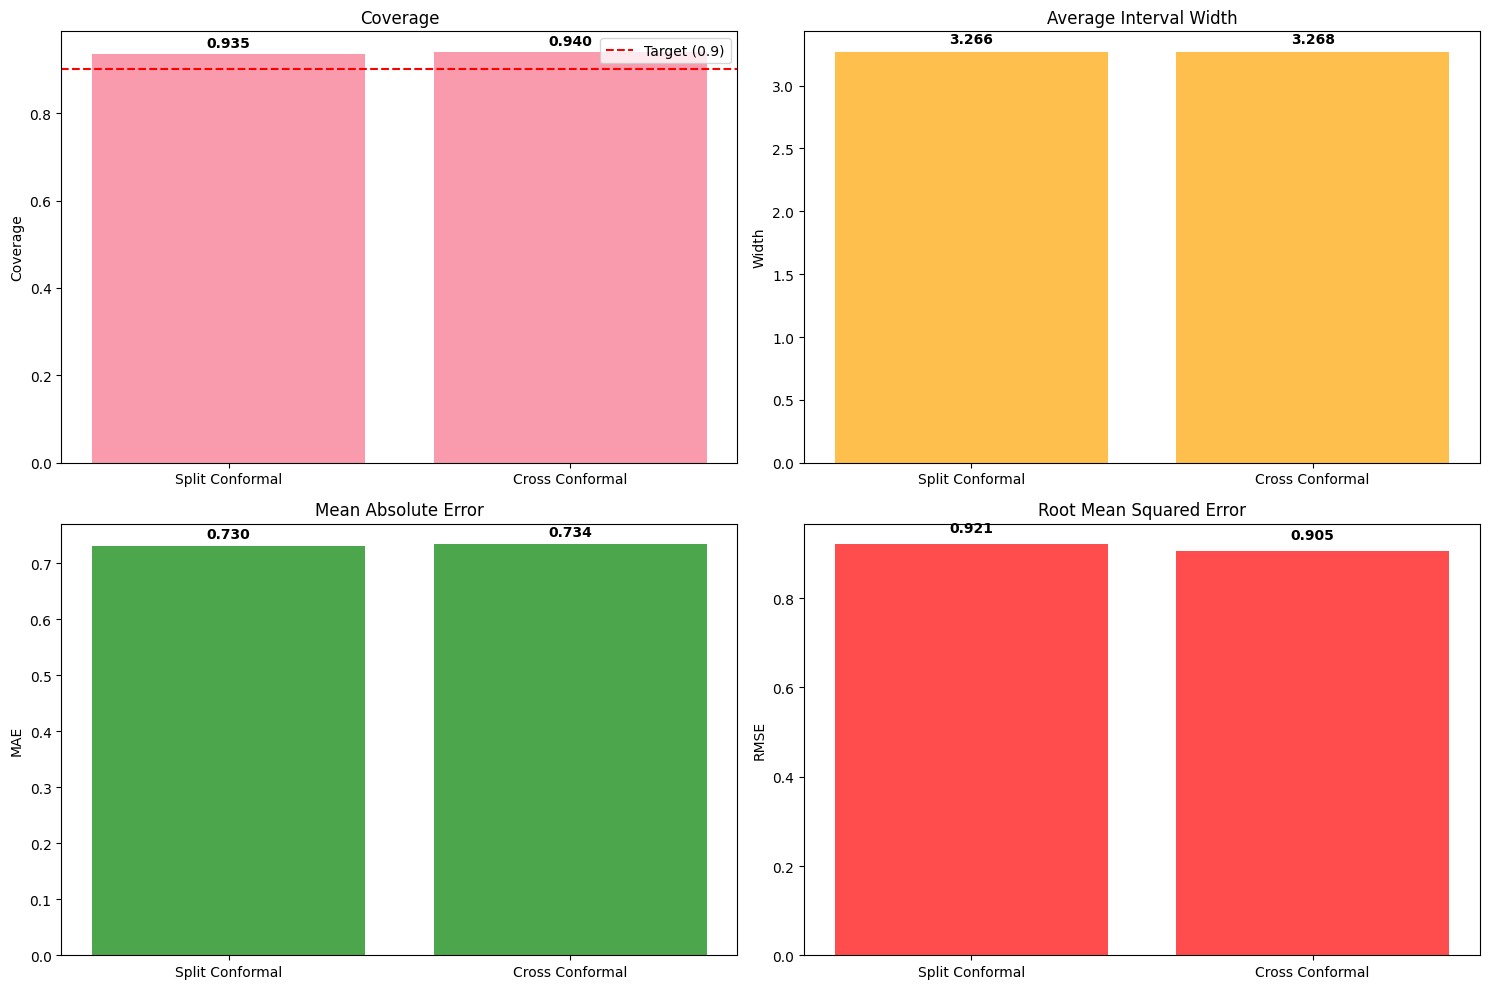

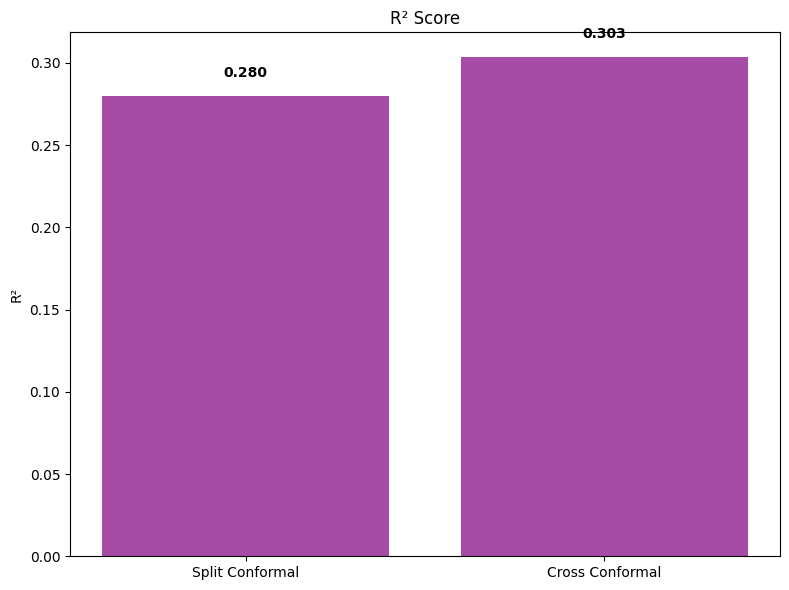

In [175]:
# Create comparison table for regression results
comparison_reg = pd.DataFrame(
    {
        "Method": ["Split Conformal", "Cross Conformal"],
        "Coverage": [results_split_reg["coverage"], results_cross_reg["coverage"]],
        "Avg Interval Width": [
            results_split_reg["avg_interval_width"],
            results_cross_reg["avg_interval_width"],
        ],
        "MAE": [results_split_reg["mae"], results_cross_reg["mae"]],
        "RMSE": [results_split_reg["rmse"], results_cross_reg["rmse"]],
        "R²": [results_split_reg["r2"], results_cross_reg["r2"]],
    },
)

print("Regression Methods Comparison:")
print("=" * 50)
print(comparison_reg.round(3))

# Visualization - removed validity check, now 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Coverage comparison
bars1 = axes[0, 0].bar(comparison_reg["Method"], comparison_reg["Coverage"], alpha=0.7)
axes[0, 0].axhline(
    y=confidence_level,
    color="red",
    linestyle="--",
    label=f"Target ({confidence_level})",
)
axes[0, 0].set_title("Coverage")
axes[0, 0].set_ylabel("Coverage")
axes[0, 0].legend()
# Add values on top of bars
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Interval width comparison
bars2 = axes[0, 1].bar(
    comparison_reg["Method"],
    comparison_reg["Avg Interval Width"],
    alpha=0.7,
    color="orange",
)
axes[0, 1].set_title("Average Interval Width")
axes[0, 1].set_ylabel("Width")
# Add values on top of bars
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.05,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# MAE comparison
bars3 = axes[1, 0].bar(
    comparison_reg["Method"], comparison_reg["MAE"], alpha=0.7, color="green",
)
axes[1, 0].set_title("Mean Absolute Error")
axes[1, 0].set_ylabel("MAE")
# Add values on top of bars
for bar in bars3:
    height = bar.get_height()
    axes[1, 0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# RMSE comparison
bars4 = axes[1, 1].bar(
    comparison_reg["Method"], comparison_reg["RMSE"], alpha=0.7, color="red",
)
axes[1, 1].set_title("Root Mean Squared Error")
axes[1, 1].set_ylabel("RMSE")
# Add values on top of bars
for bar in bars4:
    height = bar.get_height()
    axes[1, 1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.02,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# R² comparison in a separate smaller plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bars5 = ax.bar(
    comparison_reg["Method"], comparison_reg["R²"], alpha=0.7, color="purple",
)
ax.set_title("R² Score")
ax.set_ylabel("R²")
# Add values on top of bars
for bar in bars5:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

### Observations from Regression Results

The regression comparison demonstrates the effectiveness of conformal prediction for uncertainty quantification in molecular property prediction:

**Coverage Performance**: Both Split and Cross Conformal methods achieve excellent coverage (~94%), slightly exceeding the target 90% confidence level. This indicates conservative but reliable interval predictions.

**Interval Efficiency**: 
- Both methods provide wide intervals relative to the LogD value range, indicating a poor model

**Method Comparison**: Cross Conformal shows slight advantages in MAE, RMSE and R2 at the expense of interval widths. The differences are modest, suggesting both methods are viable, with Cross Conformal preferred when computational resources allow for the additional training overhead.

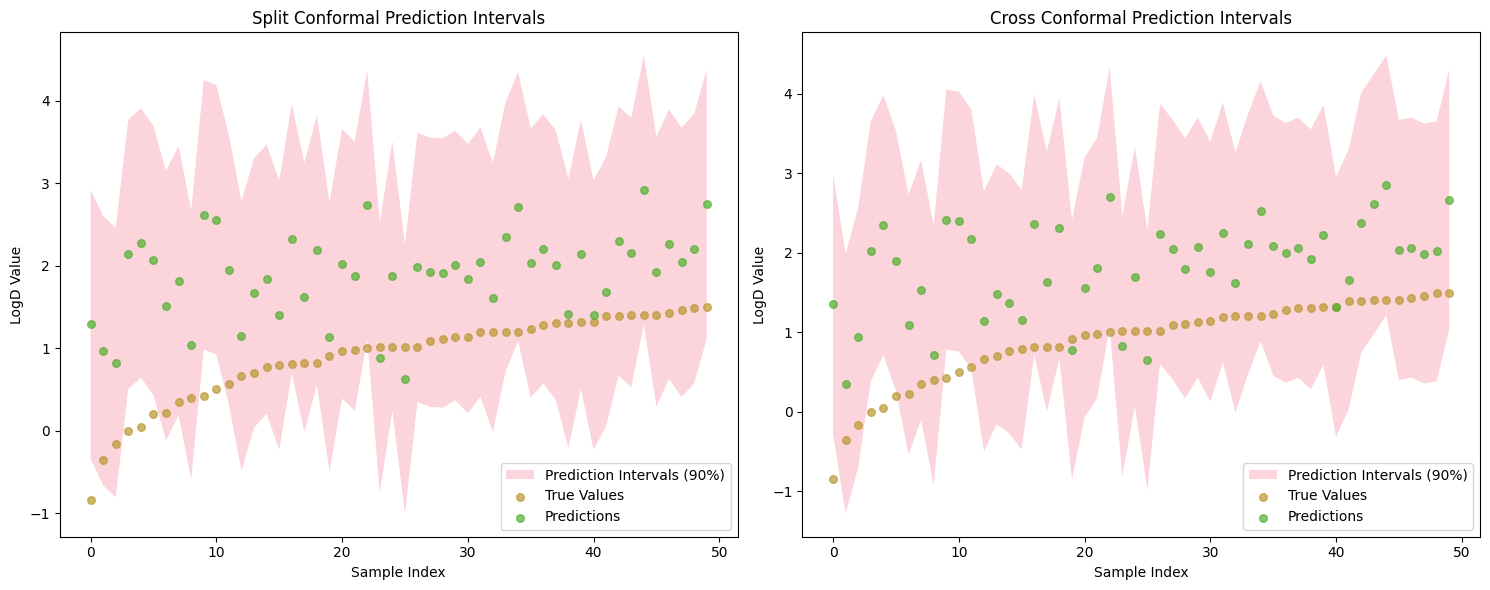

Split Conformal Coverage: 0.935
Cross Conformal Coverage: 0.940


In [176]:
# Visualize prediction intervals for regression
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sort by true values for better visualization
sort_idx = np.argsort(y_test_reg)
y_test_sorted = y_test_reg[sort_idx]
y_pred_split_sorted = y_pred_split_reg[sort_idx]
y_pred_cross_sorted = y_pred_cross_reg[sort_idx]
intervals_split_sorted = intervals_split[sort_idx]
intervals_cross_sorted = intervals_cross[sort_idx]

# Plot first 50 samples for clarity
n_plot = min(50, len(y_test_reg))

# Split conformal intervals
axes[0].fill_between(
    range(n_plot),
    intervals_split_sorted[:n_plot, 0],
    intervals_split_sorted[:n_plot, 1],
    alpha=0.3,
    label=f"Prediction Intervals ({confidence_level:.0%})",
)
axes[0].scatter(
    range(n_plot), y_test_sorted[:n_plot], alpha=0.7, label="True Values", s=30,
)
axes[0].scatter(
    range(n_plot), y_pred_split_sorted[:n_plot], alpha=0.7, label="Predictions", s=30,
)
axes[0].set_title("Split Conformal Prediction Intervals")
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("LogD Value")
axes[0].legend()

# Cross conformal intervals
axes[1].fill_between(
    range(n_plot),
    intervals_cross_sorted[:n_plot, 0],
    intervals_cross_sorted[:n_plot, 1],
    alpha=0.3,
    label=f"Prediction Intervals ({confidence_level:.0%})",
)
axes[1].scatter(
    range(n_plot), y_test_sorted[:n_plot], alpha=0.7, label="True Values", s=30,
)
axes[1].scatter(
    range(n_plot), y_pred_cross_sorted[:n_plot], alpha=0.7, label="Predictions", s=30,
)
axes[1].set_title("Cross Conformal Prediction Intervals")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("LogD Value")
axes[1].legend()

plt.tight_layout()
plt.show()

# Check coverage for each method
coverage_split = np.mean(
    (y_test_reg >= intervals_split[:, 0]) & (y_test_reg <= intervals_split[:, 1]),
)
coverage_cross = np.mean(
    (y_test_reg >= intervals_cross[:, 0]) & (y_test_reg <= intervals_cross[:, 1]),
)

print(f"Split Conformal Coverage: {coverage_split:.3f}")
print(f"Cross Conformal Coverage: {coverage_cross:.3f}")

### Observations from Prediction Intervals Visualization

The prediction interval plots provide intuitive insight into conformal prediction behavior for regression:

**Interval Coverage**: Both methods show that most predicted values (green dots) fall within the prediction intervals (shaded regions), visually confirming the high coverage rates. 

**Interval Adaptation**: 
- **Varying Widths**: Intervals show adaptive behavior, becoming wider for samples where the model is less certain and narrower where predictions are more reliable
- **Consistent Predictions**: The grren prediction points generally track close to the true values, with intervals centered around these predictions

**Method Comparison**:
- **Cross Conformal**: Shows slightly more consistent interval widths and appears to provide marginally better calibration
- **Split Conformal**: Similar behavior but with occasionally wider intervals, reflecting the smaller calibration dataset

**Practical Value**: The visualization demonstrates how conformal prediction provides actionable uncertainty estimates - narrow intervals indicate high confidence predictions suitable for decision-making, while wide intervals flag cases requiring additional investigation or experimental validation.

## 4. Effect of Confidence Level on Regression Performance

Let's analyze how different confidence levels affect the performance of cross conformal prediction for regression.

Analyzing confidence level effects on regression...
Confidence 0.70: Coverage=0.775, Avg Interval Width=2.088
Confidence 0.75: Coverage=0.830, Avg Interval Width=2.348
Confidence 0.80: Coverage=0.875, Avg Interval Width=2.621
Confidence 0.85: Coverage=0.895, Avg Interval Width=2.871
Confidence 0.90: Coverage=0.940, Avg Interval Width=3.268
Confidence 0.95: Coverage=0.970, Avg Interval Width=4.242

Regression Confidence Level Analysis Summary:
   confidence_level  coverage  avg_interval_width    mae   rmse     r2
0              0.70     0.775               2.088  0.734  0.905  0.303
1              0.75     0.830               2.348  0.734  0.905  0.303
2              0.80     0.875               2.621  0.734  0.905  0.303
3              0.85     0.895               2.871  0.734  0.905  0.303
4              0.90     0.940               3.268  0.734  0.905  0.303
5              0.95     0.970               4.242  0.734  0.905  0.303


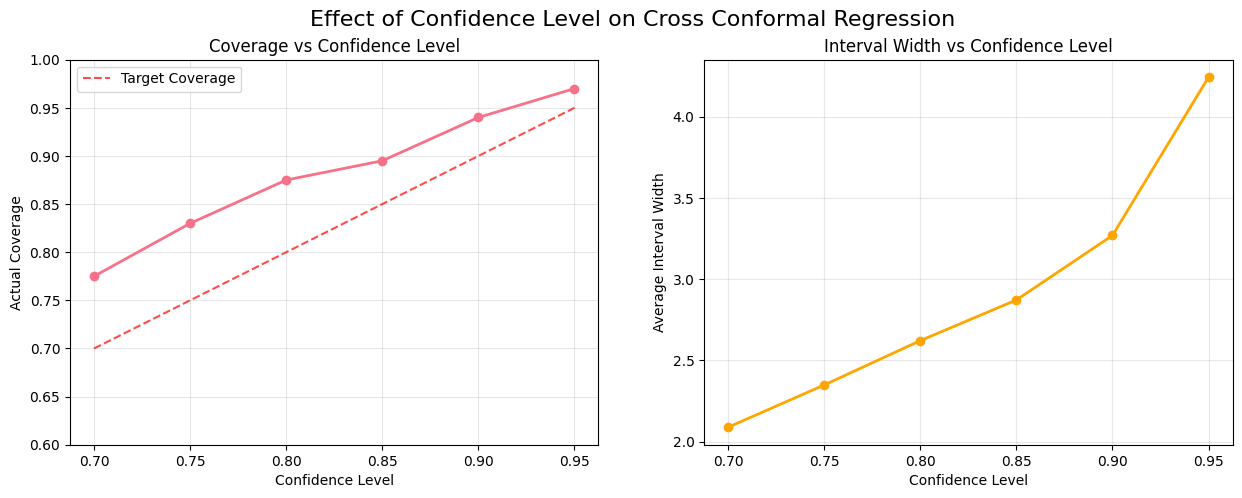

In [177]:
# Analyze different confidence levels for regression
confidence_levels = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
reg_confidence_results = []

print("Analyzing confidence level effects on regression...")
for conf_level in confidence_levels:
    # Use the already trained cross conformal predictor
    intervals_conf = cross_cp_reg.predict_int(x_test_reg, confidence=conf_level)

    # Evaluate
    results_conf = evaluate_regression_conformal(
        y_test_reg, y_pred_cross_reg, intervals_conf,
    )

    reg_confidence_results.append(
        {
            "confidence_level": conf_level,
            "coverage": results_conf["coverage"],
            "avg_interval_width": results_conf["avg_interval_width"],
            "mae": results_conf["mae"],
            "rmse": results_conf["rmse"],
            "r2": results_conf["r2"],
        },
    )

    print(
        f"Confidence {conf_level:.2f}: Coverage={results_conf['coverage']:.3f}, "
        f"Avg Interval Width={results_conf['avg_interval_width']:.3f}",
    )

# Convert to DataFrame for easier plotting
reg_conf_df = pd.DataFrame(reg_confidence_results)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Effect of Confidence Level on Cross Conformal Regression", fontsize=16)

# Coverage vs confidence level
axes[0].plot(
    reg_conf_df["confidence_level"],
    reg_conf_df["coverage"],
    "o-",
    linewidth=2,
    markersize=6,
)
axes[0].plot(
    reg_conf_df["confidence_level"],
    reg_conf_df["confidence_level"],
    "--",
    color="red",
    alpha=0.7,
    label="Target Coverage",
)
axes[0].set_xlabel("Confidence Level")
axes[0].set_ylabel("Actual Coverage")
axes[0].set_title("Coverage vs Confidence Level")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.6, 1.0)

# Interval width vs confidence level
axes[1].plot(
    reg_conf_df["confidence_level"],
    reg_conf_df["avg_interval_width"],
    "o-",
    linewidth=2,
    markersize=6,
    color="orange",
)
axes[1].set_xlabel("Confidence Level")
axes[1].set_ylabel("Average Interval Width")
axes[1].set_title("Interval Width vs Confidence Level")
axes[1].grid(True, alpha=0.3)


print("\nRegression Confidence Level Analysis Summary:")
print("=" * 60)
print(reg_conf_df.round(3))

### Observations from Confidence Level Analysis (Regression)

The confidence level analysis for regression reveals the fundamental trade-off between coverage and efficiency:

**Coverage Calibration**: The actual coverage (continuous line) closely follows the target confidence levels (dashed line), demonstrating excellent calibration. The slight over-coverage at lower confidence levels and near-perfect calibration at higher levels shows the conservative nature of conformal prediction.

**Coverage-Efficiency Trade-off**: 
- **Interval Width Growth**: As confidence increases from 70% to 95%, average interval width nearly doubles (from ~2.0 to ~4.2), illustrating the fundamental trade-off between certainty and precision
- **Linear Relationship**: The approximately linear relationship between confidence level and interval width suggests predictable scaling behavior

**Practical Implications**:
- **70-80% Confidence**: Provides narrow, actionable intervals suitable for screening applications where some false negatives are acceptable
- **85-90% Confidence**: Offers a balanced approach for most drug discovery applications, providing reliable coverage with reasonable precision
- **95% Confidence**: Ensures very high reliability but with significantly wider intervals, appropriate for safety-critical decisions

This analysis helps practitioners choose appropriate confidence levels based on their specific risk tolerance and decision-making requirements.

# Summary and Conclusions

## Key Findings

### Classification (BBBP Dataset):
- **Split Conformal Prediction**: Provides basic coverage guarantees with straightforward implementation
- **Mondrian Conformal Prediction**: Offers class-conditional coverage, ensuring coverage for each class separately
- **Cross Conformal Prediction**: More data-efficient by using all available data for both training and calibration and not relying on a single calib set

### Regression (LogD Dataset):
- **Split Conformal Prediction**: Standard approach with dedicated calibration set
- **Cross Conformal Prediction**: Better data utilization through cross-validation approach

## Practical Considerations

1. **Data Efficiency**: Cross conformal prediction typically provides better performance when data is limited, as it uses all available data for both training and calibration.

2. **Coverage Guarantees**: All methods should provide coverage at or above the specified confidence level. If coverage is below the target, consider:
   - Increasing the calibration set size
   - Checking for distribution shift between calibration and test sets
   - Using Mondrian conformal prediction for better class-conditional coverage

3. **Set Size/Interval Width**: Smaller prediction sets (classification) or narrower intervals (regression) are generally preferred, as they provide more informative predictions.

4. **Computational Cost**: Cross conformal prediction requires training multiple models, making it more computationally expensive than split conformal prediction.

5. **Performance**: Your predictor performance is expected to drop a bit in low-data regimes since we train only on 60% of the data instead of 80% due to calib set.

## Best Practices

- Always validate the conformal prediction coverage on held-out test data
- Consider the trade-off between efficiency (data usage) and computational cost
- For imbalanced classification problems, Mondrian conformal prediction can provide better class-specific coverage
- Monitor both coverage and efficiency (set size/interval width) metrics

Conformal prediction provides a powerful framework for uncertainty quantification in molecular machine learning, offering statistically valid confidence regions regardless of the underlying model architecture.